Done!:)
Map generated in 1040. try, in 22.00780415534973 seconds.


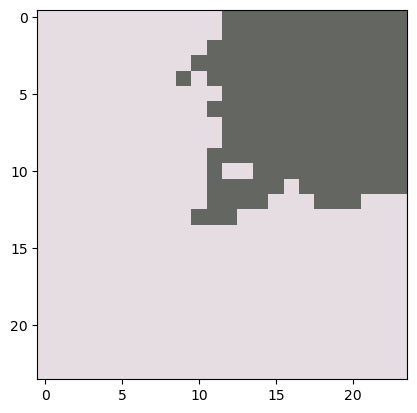

In [2]:
import numpy as np
import random
import time
import tiledict

import rotacio
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
from mpl_toolkits.axes_grid1 import ImageGrid


def form_map(n,m,tiles):
    #ez a fuggveny generalja a szuperpozicioban letezo terkepet tarolo np.arrayt
    mezok_sivatagos = {3,13,14,15,16,25,26,27,28,33,34,35,36,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184}
    mezok_fagyos = {4,17,18,19,20,29,30,31,32,37,38,39,40,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256}
    harmasmezok = set(range(113,257))
    output = np.full((n,m),{})
    #ha kicsi a terkep, korlatozza a hasznalando mezok listajat
    if 13 > n or 13 > m:
        for i in range(n):
            for j in range(m):
                output[i][j] = set(range(len(tiles)))
                output[i][j].difference_update(harmasmezok)
                output[i][j].difference_update(mezok_fagyos)
                output[i][j].difference_update(mezok_sivatagos)
    else:
        for i in range(n):
            for j in range(m):
                output[i][j] = set(range(len(tiles)))
                if i < n//3 or n-(n//3) < i:    #sivatag ne legyen a sarkokon
                    output[i][j].difference_update(mezok_sivatagos)
                if n//7 < i and i < n-(n//7):     #fagy ne legyen kozepen
                    output[i][j].difference_update(mezok_fagyos)
                if i == 0 or j == 0 or i == n-1 or j == m-1:    #viz a szeleken
                    output[i][j] = {2}
                if i == 1:
                    output[i][j].intersection_update(tiledict.tiles[2]["lentszomszed"])
                if j == 1:
                    output[i][j].intersection_update(tiledict.tiles[2]["jobbszomszed"])
                if i == n-2:
                    output[i][j].intersection_update(tiledict.tiles[2]["fentszomszed"])
                if j == m-2:
                    output[i][j].intersection_update(tiledict.tiles[2]["balszomszed"])
                        
    return output

vizes = {2,9,10,11,12,21,22,23,24,33,34,35,36,37,38,39,40,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96}
vizes.union(set(range(113,242)))

def generate_map(n,m,tries = 0,time_elapsed = 0):
    start_time = time.time()
    no_of_tiles = len(tiledict.tiles)
    output = form_map(n,m,tiledict.tiles)
    generating = True
    me_tile = (0,0,no_of_tiles)
    
    
    
    tile_states = np.zeros((n,m))
    for i in range(n):
            for j in range(m):
                tile_states[i][j] = len(output[i][j])
    while(generating):
        
        me_tile = (me_tile[0],me_tile[1],no_of_tiles)
        
        #legkissebb entropiaju pozicio keresese
        for i in range(n):
            for j in range(m):
                if len(output[i][j]) < me_tile[2] and tile_states[i][j] != 1:
                    tile_states[i][j] = len(output[i][j])
                    me_tile = (i,j,len(output[i][j]))
        
             
        #legkissebb entropiaju pozicio kitoltese
        options = output[me_tile[0]][me_tile[1]]
        #print(f"tile:{me_tile}, picking from {len(options)} options")
        if len(options) == 0:
            tries = tries + 1
            #print(f"{tries}. try failed, retrying...")
            time_elapsed += time.time() - start_time      
            return generate_map(n,m,tries,time_elapsed)
        
        #ez noveli az eselyet annak h egyszeru mezoket valaszt
        chancemaker = random.random()                               #ezeken a szamokon lehet finomhangolni hogy gyors, de erdekes legyen a map
        if  not set(range(5)).isdisjoint(options) and chancemaker < 0.33 + tries / 4400:
            options.intersection_update(set(range(5)))
        if  not set(range(41)).isdisjoint(options) and chancemaker < 0.44 + tries / 4400:
            options.intersection_update(set(range(41)))
        if  not set(range(113)).isdisjoint(options) and chancemaker < 0.55 + tries / 4400:
            options.intersection_update(set(range(113)))
        # 0-4 : egyszinu
        # 5-40 : feles
        # 41-112 : sarok
        # 113-256 : haromszinu
        
        #legyen kevesebb viz - mert ugy erzem jonak:
        chancemaker = random.random()
        if not options.issubset(vizes) and chancemaker < 0.66:
            options.difference_update(vizes)
        
        
        collapse = random.choice(list(options))
        output[me_tile[0]][me_tile[1]] = {collapse}
        #print(f"collapsed to {collapse}")
        tile_states[me_tile[0]][me_tile[1]] = 1
        
        #propagation
        #felette
        if me_tile[0] > 0 and tile_states[me_tile[0]-1][me_tile[1]] != 1:
                output[me_tile[0]-1][me_tile[1]].intersection_update(tiledict.tiles[collapse]["fentszomszed"])
        #jobbra
        if m-1 > me_tile[1] and tile_states[me_tile[0]][me_tile[1]+1] != 1:
                output[me_tile[0]][me_tile[1]+1].intersection_update(tiledict.tiles[collapse]["jobbszomszed"])
        #alatta
        if n-1 > me_tile[0] and tile_states[me_tile[0]+1][me_tile[1]] != 1:
                output[me_tile[0]+1][me_tile[1]].intersection_update(tiledict.tiles[collapse]["lentszomszed"])
        #balra
        if me_tile[1] > 0 and tile_states[me_tile[0]][me_tile[1]-1] != 1:
                output[me_tile[0]][me_tile[1]-1].intersection_update(tiledict.tiles[collapse]["balszomszed"])
        #sarkok  -- ee ez túlbonyolítja a dolgokat; no mindegy
        #bal fent
        # if me_tile[0] > 0 and me_tile[1] > 0 and tile_states[me_tile[0]-1][me_tile[1]-1] != 1:
        #         output[me_tile[0]-1][me_tile[1]].intersection_update(tiledict.tiles[collapse]["sarok1"])
        # #jobb fent
        # if me_tile[0] > 0 and m-1 > me_tile[1] and tile_states[me_tile[0]-1][me_tile[1]+1] != 1:
        #         output[me_tile[0]][me_tile[1]+1].intersection_update(tiledict.tiles[collapse]["sarok2"])
        # #jobb lent
        # if n-1 > me_tile[0] and m-1 > me_tile[1] and tile_states[me_tile[0]+1][me_tile[1]+1] != 1:
        #         output[me_tile[0]+1][me_tile[1]].intersection_update(tiledict.tiles[collapse]["sarok3"])
        # #bal lent
        # if n-1 > me_tile[0] and me_tile[1] > 0 and tile_states[me_tile[0]+1][me_tile[1]-1] != 1:
        #         output[me_tile[0]][me_tile[1]-1].intersection_update(tiledict.tiles[collapse]["sarok4"])
                
        #ha mar minden mezo kitoltetett akkor alljon le
        if np.array_equal(tile_states,np.ones((n,m))):
            generating = False
    print("Done!:)")
    print(f"Map generated in {tries+1}. try, in {time.time()-start_time+time_elapsed} seconds.")
    return output



map_0 = generate_map(15,17)

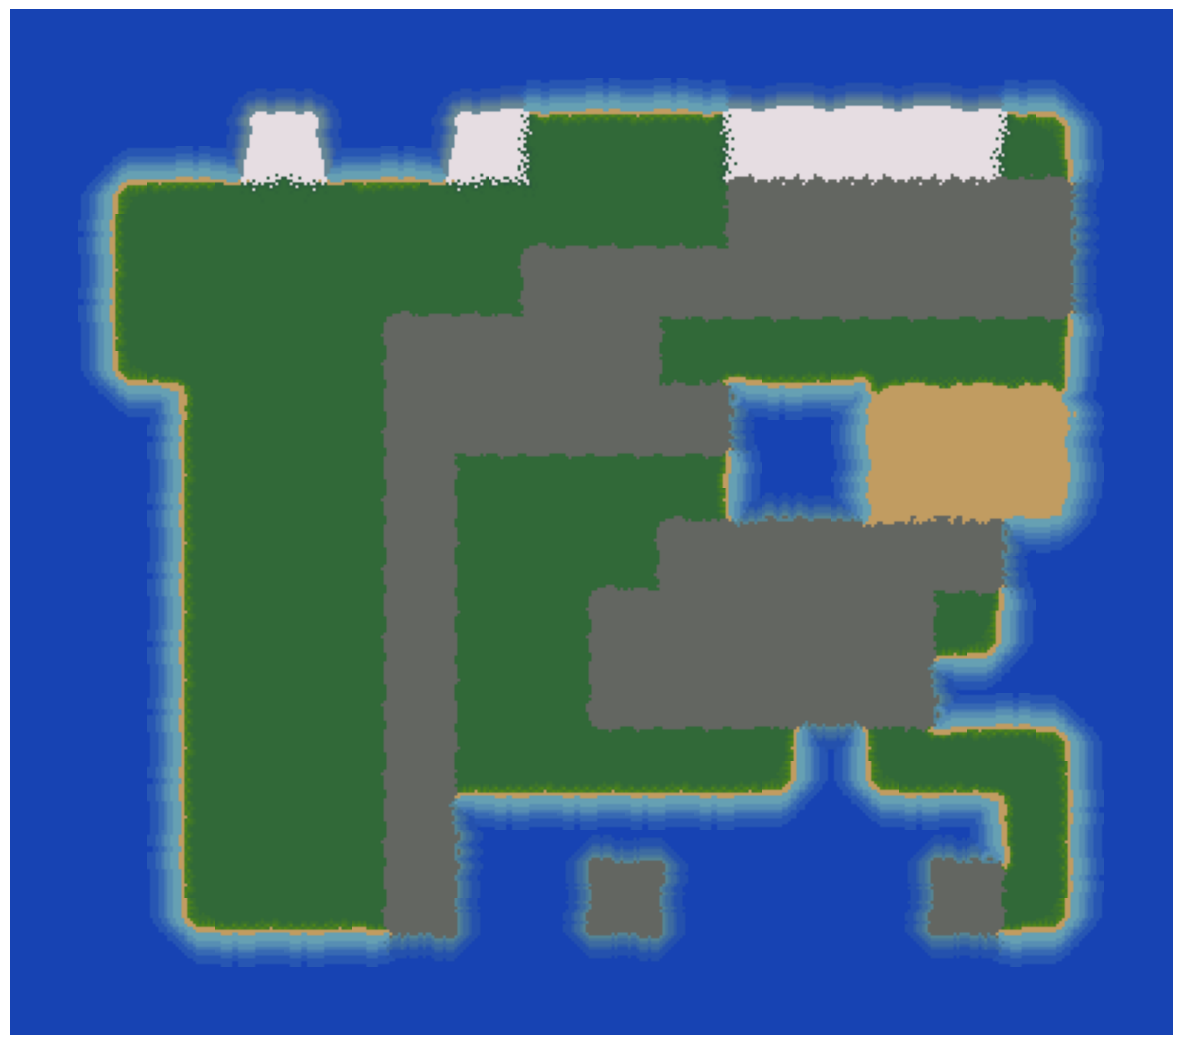

In [3]:
def megjelenito(generated_map):
    x = np.shape(generated_map)[0]
    y = np.shape(generated_map)[1]
    fig = plt.figure(figsize=(x, y))
    grid = ImageGrid(fig, 111, 
        nrows_ncols=(x, y),
        axes_pad = 0
        )
    img_arr = []
    for i in range(x):
        for j in range(y):
            img_arr.append(rotacio.forgato(list(generated_map[i][j])[0]))

    for ax, im in zip(grid, img_arr):
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.imshow(im)
        ax.axis("off")
    plt.show()
    

megjelenito(map_0)